In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

/tmp/ipython-input-19-2040266865.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [20]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')
labels = data[:,0]
data = data[:,1:]


Text(0.5, 1.0, 'Histogram of Normalised Data')

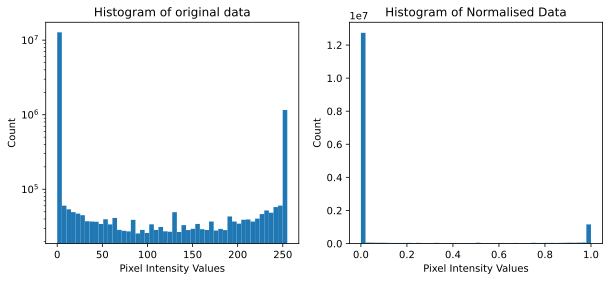

In [21]:
dataNorm = data/np.max(data)
fig,ax = plt.subplots(1,2,figsize = (10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel Intensity Values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[0].set_yscale('log')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel Intensity Values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of Normalised Data')

In [22]:
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()
train_data,test_data,train_labels,test_labels = train_test_split(dataT,labelsT,test_size = .1)
train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)
batchsize = 32
train_loader = DataLoader(train_data,batch_size= batchsize,shuffle = True,drop_last = True)
test_loader = DataLoader (test_data,batch_size = test_data.tensors[0].shape[0])

In [23]:
def createTheMNISTNet():
  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.input = nn.Linear(784,64)
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)
      self.output = nn.Linear(32,10)
    def forward(self,x):
      x = F.relu(self.input(x))
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      return torch.log_softmax(self.output(x),axis = 1)
  net = mnistNet()
  lossfun = nn.NLLLoss()
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)
  return net,lossfun,optimizer

In [24]:
net,lossfun,optimizer = createTheMNISTNet()
X, y = next(iter(train_loader))
y = y.squeeze()
yHat = net(X)
print(yHat)
loss = lossfun(yHat,y)
print('')
print('Loss:')
print(loss)

tensor([[-2.1743, -2.2465, -2.4382, -2.2659, -2.2263, -2.5315, -2.1826, -2.4588,
         -2.2260, -2.3457],
        [-2.1593, -2.2589, -2.4565, -2.2668, -2.2067, -2.5339, -2.1780, -2.4671,
         -2.2167, -2.3614],
        [-2.1700, -2.2427, -2.4297, -2.2748, -2.2223, -2.5336, -2.1959, -2.4597,
         -2.2158, -2.3511],
        [-2.1802, -2.2483, -2.4282, -2.2691, -2.2263, -2.5317, -2.1843, -2.4575,
         -2.2268, -2.3407],
        [-2.1705, -2.2525, -2.4439, -2.2780, -2.2030, -2.5375, -2.1775, -2.4678,
         -2.2152, -2.3572],
        [-2.1685, -2.2587, -2.4461, -2.2701, -2.2089, -2.5377, -2.1737, -2.4670,
         -2.2212, -2.3510],
        [-2.1751, -2.2563, -2.4547, -2.2725, -2.2024, -2.5300, -2.1698, -2.4676,
         -2.2157, -2.3595],
        [-2.1743, -2.2611, -2.4545, -2.2726, -2.1902, -2.5383, -2.1646, -2.4806,
         -2.2107, -2.3632],
        [-2.1781, -2.2540, -2.4417, -2.2577, -2.2189, -2.5356, -2.1615, -2.4753,
         -2.2335, -2.3457],
        [-2.1777, -

In [25]:
def function2TrainTheModel():
  numepochs = 60
  net,lossfun,optimizer = createTheMNISTNet()
  losses = torch.zeros(numepochs)
  trainAcc = []
  testAcc = []
  for epochi in range(numepochs):
    batchLoss =[]
    batchAcc =[]
    for X,y in train_loader:
      yHat = net(X)
      loss = lossfun(yHat,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      batchLoss.append(loss.item())
      matches = torch.argmax(yHat,axis = 1) ==y
      matchesNumeric = matches.float()
      accuracyPct = 100*torch.mean(matchesNumeric)
      batchAcc.append(accuracyPct)
    trainAcc.append(np.mean(batchAcc))
    losses[epochi] = np.mean(batchLoss)
    X,y = next(iter(test_loader))
    yHat = net(X)
    testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
  return trainAcc,testAcc,losses,net

In [26]:
trainAcc,testAcc,losses,net = function2TrainTheModel()

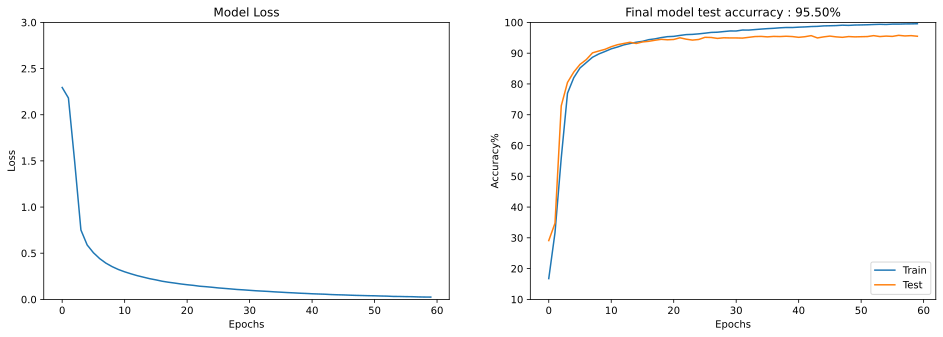

In [27]:
fig,ax = plt.subplots(1,2,figsize=(16,5))
ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model Loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label = 'Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy%')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accurracy : {testAcc[-1]:.2f}%')
ax[1].legend()

In [32]:
X, y = next(iter(test_loader))
predictions = net(X).detach()
torch.exp(predictions)

tensor([[3.6914e-08, 2.2164e-11, 9.9999e-01,  ..., 5.0690e-09, 1.4756e-09,
         3.6073e-16],
        [1.1605e-08, 1.3100e-09, 1.1843e-10,  ..., 8.3393e-08, 3.4064e-07,
         9.4496e-07],
        [3.4854e-10, 2.1421e-14, 2.4547e-15,  ..., 8.3069e-08, 1.7222e-07,
         1.0000e+00],
        ...,
        [1.5534e-10, 2.1860e-06, 2.3457e-09,  ..., 1.6759e-07, 2.1225e-04,
         1.3821e-06],
        [8.6796e-11, 5.5122e-06, 4.2057e-06,  ..., 9.9305e-01, 5.4691e-04,
         6.3422e-03],
        [1.1430e-10, 5.5264e-16, 1.3447e-17,  ..., 4.0418e-17, 8.0654e-06,
         2.4166e-11]])

Text(0.5, 1.0, 'True number was 2')

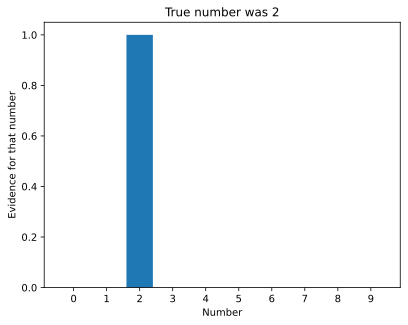

In [34]:
sample2show = 120
plt.bar(range(10),torch.exp(predictions[sample2show]))
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %y[sample2show].item())

[  34   38   43   58   93   95  116  136  138  139  160  162  177  238
  300  312  323  349  365  370  420  430  451  469  484  516  544  547
  573  609  625  636  640  647  660  691  730  735  743  758  767  785
  836  849  860  865  889  930 1083 1084 1123 1130 1154 1177 1186 1201
 1287 1308 1309 1318 1330 1393 1473 1490 1493 1518 1528 1538 1548 1563
 1579 1629 1634 1647 1678 1705 1723 1737 1758 1768 1769 1779 1781 1802
 1837 1843 1878 1905 1972 1981]


/tmp/ipython-input-35-3247172407.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))


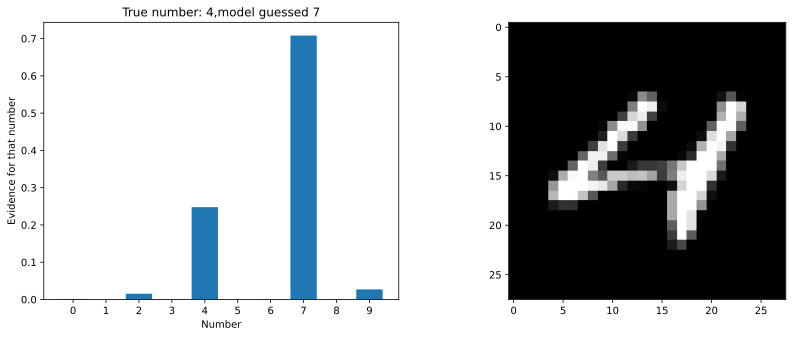

In [35]:
errors = np.where(torch.max(predictions,axis=1)[1]!=y)[0]
print(errors)
sample2show = 1
fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s,model guessed %s'
               %(y[errors[sample2show]].item(),torch.argmax(predictions[errors[sample2show]]).item()))
ax[1].imshow(np.reshape(X[errors[sample2show],:],(28,28)),cmap='gray')

array([], dtype=int64)